In [1]:
import numpy as np
from pathlib import Path
# from keras.models import Sequential
from sklearn.model_selection import train_test_split
from utils import load_audio_data, extract_mfcc
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [ ]:
# Load audio data
# dataset is from https://github.com/Jakobovski/free-spoken-digit-dataset
data_dir = Path.cwd().parent / "dataset"
f_s = 8000
X, y = load_audio_data(data_dir, f_s)

Loaded 3000 files.


In [4]:
# Convert list of samples to DataFrame
audio_df = pd.DataFrame({'audio': X, 'label': y})
audio_df.head()

,audio,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0078125...",5
1,"[9.1552734e-05, -0.0005187988, -6.1035156e-05,...",3
2,"[-0.0005493164, -0.00048828125, -0.00048828125...",1
3,"[-0.0014953613, -0.0008239746, 0.001159668, -0...",2
4,"[0.0, 9.1552734e-05, 9.1552734e-05, 0.00018310...",4


In [5]:
# Extract MFCC features
n_mfcc = 13  # Number of MFCC features to extract
mfcc_features = extract_mfcc(X, n_mfcc, f_s)

In [23]:
# Find the maximum length of MFCC features
max_len = max(m.shape[0] for m in mfcc_features)
min_len = min(m.shape[0] for m in mfcc_features)

In [7]:
# find the number of sample with the maximum length
max_sample_index = np.argmax([m.shape[0] for m in mfcc_features])
min_sample_index = np.argmin([m.shape[0] for m in mfcc_features])

In [8]:
min_sample_index, max_sample_index

(np.int64(2578), np.int64(2079))

In [24]:
min_len, max_len

(9, 143)

In [25]:
mfcc_features[2079].shape

(143, 13)

In [11]:
# calculaet the stft from one sample from X
stft_features = np.abs(tf.signal.stft(X[578], frame_length=256, frame_step=128, fft_length=256))


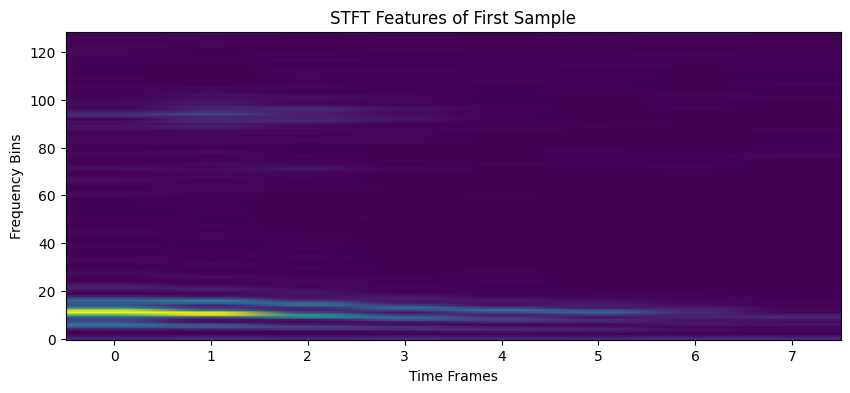

In [12]:
# plot the STFT features of the first sample from X
plt.figure(figsize=(10, 4))
plt.imshow(stft_features.T, aspect='auto', origin='lower')
plt.title('STFT Features of First Sample')
plt.ylabel('Frequency Bins')
plt.xlabel('Time Frames')
plt.show()


Text(0, 0.5, 'Time Frames')

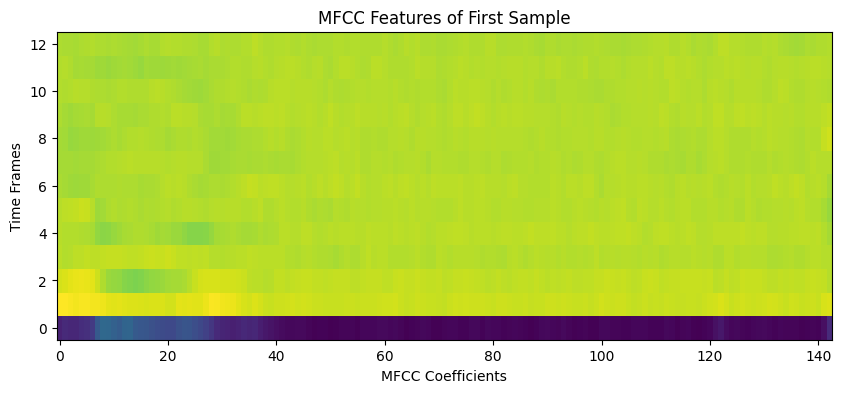

In [13]:
# plot the mfcc features of the first sample
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_features[2079].T, aspect='auto', origin='lower')
plt.title('MFCC Features of First Sample')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Time Frames')

In [ ]:
# Pad or truncate each MFCC array to max_len for consistent input shape
mfcc_padded = []
for m in mfcc_features:
    if m.shape[0] < max_len:
        # Pad with zeros if shorter than max_len
        padded = np.pad(m, ((0, max_len - m.shape[0]), (0, 0)), mode='constant')
        mfcc_padded.append(padded)

In [38]:
# convert to numpy array
X_mfcc = np.array(mfcc_padded)
# flatten the frames and mfcc_coef dimensions for each sample
X_ffnn = X_mfcc.reshape(X_mfcc.shape[0], -1)

In [39]:
# Convert labels to numpy array
y = np.array(y)

In [40]:
X_mfcc.shape

(3000, 143, 13)

In [43]:
test_size = 0.2
random_state = 42
# Determine feature size for input layer
feature_size = X_ffnn.shape[1]

In [44]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ffnn, y, test_size=test_size, random_state=random_state)

In [45]:
# Define a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(feature_size,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [46]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9136 - loss: 0.2770 - val_accuracy: 0.8550 - val_loss: 0.7021
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9039 - loss: 0.3013 - val_accuracy: 0.8617 - val_loss: 0.8209
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9356 - loss: 0.2542 - val_accuracy: 0.8783 - val_loss: 0.7407
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9463 - loss: 0.1824 - val_accuracy: 0.8850 - val_loss: 0.7575
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9488 - loss: 0.2129 - val_accuracy: 0.8833 - val_loss: 0.6831
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9429 - loss: 0.1661 - val_accuracy: 0.8917 - val_loss: 0.7072
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9482 - loss: 0.1627 - val_accuracy: 0.8933 - val_loss: 0.6604
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9562 - loss: 0.1597 - val_accuracy: 0.8650 - v

In [50]:
# Print model summary (shows layers, output shapes, and parameter counts)
model.summary()

# Calculate and print model size in bytes, KB, and MB
model_size = model.count_params() * 4  # 4 bytes per float32 parameter
print(f"Model parameters: {model.count_params()}")
print(f"Model size: {model_size / 1024:.2f} KB ({model_size / (1024*1024):.2f} MB)")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        59,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,552 (701.38 KB)

 Trainable params: 59,850 (233.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 119,702 (467.59 KB)

Model parameters: 59850
Model size: 233.79 KB (0.23 MB)


In [ ]:
# Save the trained Keras model
# model.save("speech2digits_model.h5")

## Convert model into TFL

In [51]:
# Optional: representative dataset for quantization
def representative_data_gen():
    for input_value in X_train.astype(np.float32):
        yield [np.expand_dims(input_value, 0)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

tflite_model = converter.convert()

# Save as .tflite file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/w2/5llw5nk57xj1c2hgtm1874j00000gn/T/tmpg1_9uzb3/assets


INFO:tensorflow:Assets written to: /var/folders/w2/5llw5nk57xj1c2hgtm1874j00000gn/T/tmpg1_9uzb3/assets


Saved artifact at '/var/folders/w2/5llw5nk57xj1c2hgtm1874j00000gn/T/tmpg1_9uzb3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1859), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  5718519504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5718518928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5718517776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5718517200: TensorSpec(shape=(), dtype=tf.resource, name=None)


/Users/anatolii/Documents/Projects/speech2digits/.venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1751040002.862130  104789 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751040002.865748  104789 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-27 18:00:02.866948: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/w2/5llw5nk57xj1c2hgtm1874j00000gn/T/tmpg1_9uzb3
2025-06-27 18:00:02.867239: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-27 18:00:02.867245: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/w2/5llw5nk57xj1c2hgtm1874j00000gn/T/tmpg1_9uzb3
I0000 00:00:1751040002.869534  104789 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


#### Test the model on dummy data

In [53]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Make sure input shape matches your preprocessed data!
test_input = np.zeros(input_details[0]['shape'], dtype=np.int8)
interpreter.set_tensor(input_details[0]['index'], test_input)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
predicted_digit = np.argmax(output)
print(predicted_digit)

1


#### Test the model on quantized Valiation data


In [63]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

correct = 0
total = len(X_test)

input_scale, input_zero_point = input_details[0]['quantization']

# Example for one sample
for i in range(total):
    x = X_test[i]
    x_quant = np.round(x / input_scale + input_zero_point).astype(np.int8)
    x_quant = np.expand_dims(x_quant, axis=0)  # Add batch dimension
    
    interpreter.set_tensor(input_details[0]['index'], x_quant)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_digit = np.argmax(output)

    if predicted_digit == y_test[i]:
        correct += 1

accuracy  = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.83%


/Users/anatolii/Documents/Projects/speech2digits/.venv/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
